<a href="https://colab.research.google.com/github/Daniel1989/fastai_course/blob/main/fastai_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import requests
import os
from google.colab import userdata
# Replace with your Pexels API key
API_KEY = userdata.get('PEXELS_API_KEY')
BASE_URL = "https://api.pexels.com/v1/search"

def search_and_download_images(query, num_images=5):
    save_dir = "./downloaded_images/"+query
    # Create save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Set up headers with API key
    headers = {
        "Authorization": API_KEY
    }

    # Set up parameters for the API request
    params = {
        "query": query,
        "per_page": num_images
    }

    try:
        # Make the API request
        response = requests.get(BASE_URL, headers=headers, params=params)
        response.raise_for_status()  # Raise an exception for bad status codes

        # Parse the JSON response
        data = response.json()
        photos = data.get("photos", [])

        if not photos:
            print("No images found for the query.")
            return

        # Download each image
        for i, photo in enumerate(photos, 1):
            image_url = photo["src"]["original"]
            image_extension = image_url.split(".")[-1]
            filename = f"{save_dir}/{query.replace(' ', '_')}_{i}.{image_extension}"

            # Download the image
            image_response = requests.get(image_url)
            image_response.raise_for_status()

            # Save the image locally
            with open(filename, "wb") as f:
                f.write(image_response.content)
            print(f"Downloaded: {filename}")

    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")


In [20]:
# 这个包含了fastai框架
!pip install -Uqq fastbook

In [2]:
# 初始化
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [21]:
number_of_images = 100
search_and_download_images("cat", number_of_images)
search_and_download_images("dog", number_of_images)
search_and_download_images("bird", number_of_images)

Downloaded: ./downloaded_images/cat/cat_1.jpeg
Downloaded: ./downloaded_images/cat/cat_2.jpeg
Downloaded: ./downloaded_images/cat/cat_3.jpeg
Downloaded: ./downloaded_images/cat/cat_4.jpeg
Downloaded: ./downloaded_images/cat/cat_5.jpeg
Downloaded: ./downloaded_images/cat/cat_6.jpeg
Downloaded: ./downloaded_images/cat/cat_7.jpeg
Downloaded: ./downloaded_images/cat/cat_8.jpg
Downloaded: ./downloaded_images/cat/cat_9.jpeg
Downloaded: ./downloaded_images/cat/cat_10.jpeg
Downloaded: ./downloaded_images/cat/cat_11.jpeg
Downloaded: ./downloaded_images/cat/cat_12.jpeg
Downloaded: ./downloaded_images/cat/cat_13.jpeg
Downloaded: ./downloaded_images/cat/cat_14.jpeg
Downloaded: ./downloaded_images/cat/cat_15.jpeg
Downloaded: ./downloaded_images/cat/cat_16.jpeg
Downloaded: ./downloaded_images/cat/cat_17.jpeg
Downloaded: ./downloaded_images/cat/cat_18.jpeg
Downloaded: ./downloaded_images/cat/cat_19.jpeg
Downloaded: ./downloaded_images/cat/cat_20.jpeg
Downloaded: ./downloaded_images/cat/cat_21.jpeg
Do

In [22]:
from fastbook import *
from fastai.vision.widgets import *
# 5个组成部分，block，一个
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # 前者自变量是我们用来进行预测的因素，而后者因变量是我们的目标。
    get_items=get_image_files, # get_image_files function takes a path, and returns a list of all of the images in that path (recursively, by default)
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # seed通过提供同样的启动点，来确保创建的数值一致
    get_y=parent_label, # 一个function 获取y的label
    item_tfms=Resize(128)) # 将所有图片弄成一个size，这样产生的tensorsize才一致

In [23]:
path = Path('downloaded_images')
dls = bears.dataloaders(path)


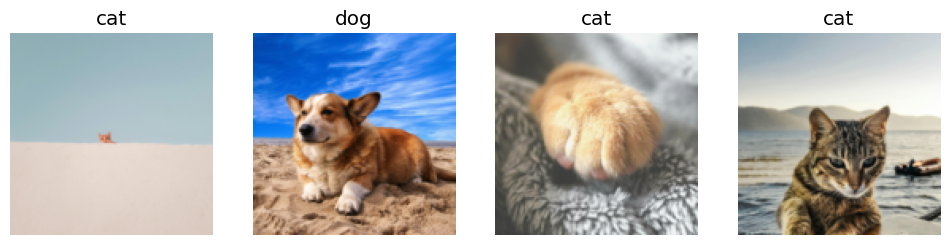

In [24]:
dls.valid.show_batch(max_n=4, nrows=1)


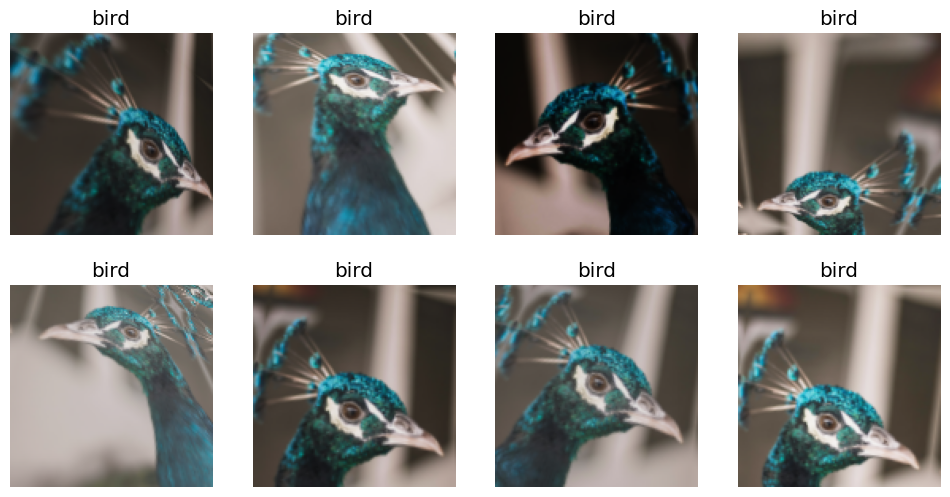

In [25]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
# TODO 如果数据太少，这里会报错，找不到batch
# 当使用DataBlock时，默认的batchSize是64
# 可以通过如下方式修改

# dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
#                    get_items=get_image_files,
#                    get_y=parent_label,
#                    splitter=RandomSplitter())
# dls = dblock.dataloaders(path, bs=32) 这里使用bs参数进行设置

dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [26]:
# within an epoch in fastai,
# all images are first processed with RandomResizedCrop individually,
# then batched,
# and afterward, the images in each batch are processed with aug_transforms before the resulting batch is passed to the model for training.
# This reflects the typical workflow in fastai’s data pipeline.


bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [27]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,2.141114,0.676987,0.270833,00:58


epoch,train_loss,valid_loss,error_rate,time
0,0.764760,0.315783,0.187500,00:58
1,0.500452,0.170983,0.041667,00:59
2,0.383639,0.168544,0.041667,00:59
3,0.305760,0.190339,0.062500,00:57


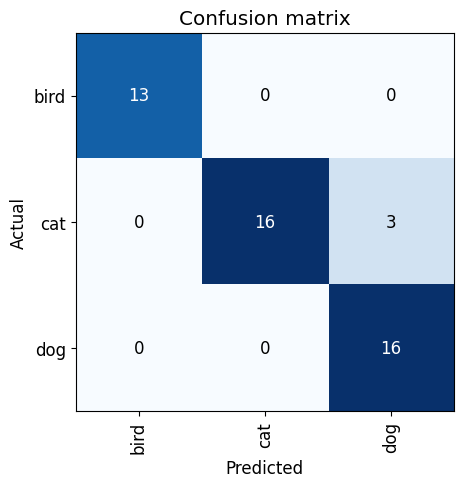

In [28]:

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

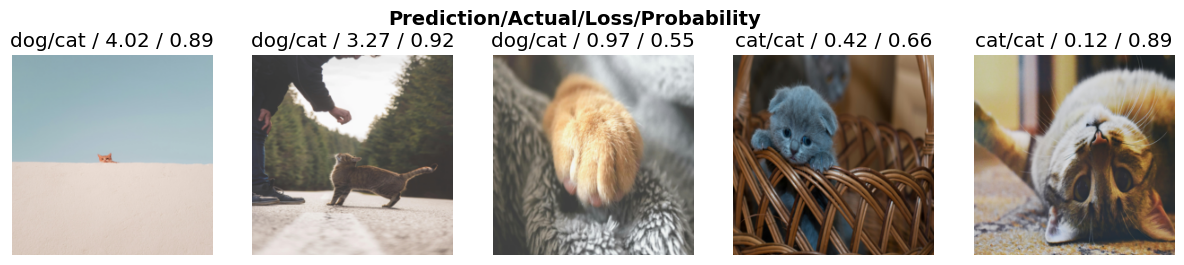

In [29]:
interp.plot_top_losses(5, nrows=1)


In [30]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
# 修改后，使用下面的语句使得真正的生效
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [31]:
learn.export()

In [32]:
# 导出
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [33]:
# 导入
learn_inf = load_learner(path/'export.pkl')

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [34]:
# 预测分类，分类索引（从词汇表获取），概率
learn_inf.predict('./downloaded_images/dog/dog_69.jpeg')

('dog', tensor(2), tensor([9.5127e-07, 1.2904e-05, 9.9999e-01]))

In [35]:
learn_inf.dls.vocab


['bird', 'cat', 'dog']

In [36]:
from fastbook import *
from fastai.vision.widgets import *
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [37]:
# 对图片类型有要求，svg不支持
img = PILImage.create(btn_upload.data[-1])
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))

out_pl

Output()

In [39]:
pred,pred_idx,probs = learn_inf.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: dog; Probability: 0.9999')

In [40]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [41]:
# 绑定事件
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)


In [42]:
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])

In [43]:
!pip install voila
!jupyter serverextension enable voila --sys-prefix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 6.1.12
    Uninstalling jupyter-client-6.1.12:
      Successfully uninstalled jupyter-client-6.1.12
  Attempting uninstall: jupyter-server
    Found existing installation: jupyter-server 1.16.0
    Uninstalling jupyter-server-1.16.0:
      Successfully uninstalled jupyter-server-1.16.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 6.5.7 requires jupyter-client<8,>=5.3.4, but you

In [ ]:
# 完整的推广流程
# 1. 先人肉check
# 2. 然后小范围推广
# 3. 然后大范围推广